In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [21]:
#Import alexnet and freeze all layers

alexnet = torchvision.models.alexnet(pretrained=True)

for p in alexnet.parameters():
    p.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 180MB/s]


In [22]:
#Put model on eval
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [24]:
#Push model to GPU
alexnet.to(device);

In [25]:
content_img = plt.imread('road_image.jpg')
style_img   = plt.imread('styleImage.png')

In [26]:
#Create target image using random values
target_img = np.random.randint(low = 0, high = 255, size = content_img.shape, dtype=np.uint8)

In [27]:
print(content_img.shape)
print(target_img.shape)
print(style_img.shape)

(600, 800, 3)
(600, 800, 3)
(159, 318, 3)


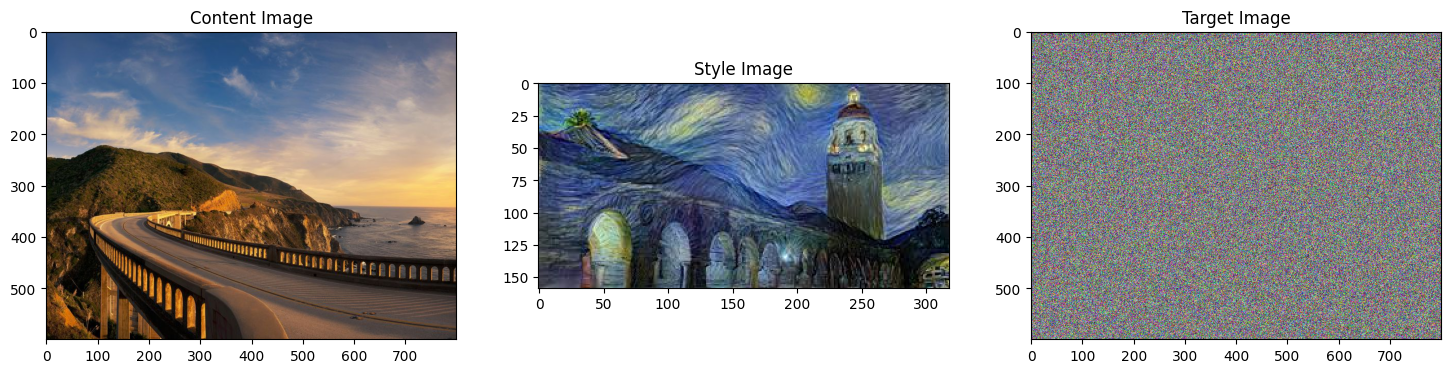

In [28]:
fig,ax = plt.subplots(1,3,figsize=(18,6))

ax[0].imshow(content_img)
ax[0].set_title('Content Image')

ax[1].imshow(style_img)
ax[1].set_title('Style Image')

ax[2].imshow(target_img)
ax[2].set_title('Target Image')

plt.show()

In [29]:
#Define transforms
Transform = transforms.Compose([ transforms.ToTensor(),
                 transforms.Resize(256),
                 transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
               ])

In [30]:
#Apply transforms and convert to 4D
content_img = Transform( content_img ).unsqueeze(0).to(device)
style_img   = Transform( style_img  ).unsqueeze(0).to(device)
target_img  = Transform( target_img  ).unsqueeze(0).to(device)

In [31]:
print(content_img.shape)
print(target_img.shape)
print(style_img.shape)

torch.Size([1, 3, 256, 341])
torch.Size([1, 3, 256, 341])
torch.Size([1, 3, 256, 512])


In [32]:
# Import functions for extracting features and creating gram matrix
from functions import Extract_FeatureMap, Gram_Matrix

In [33]:
contentFeatureMaps,contentFeatureLayers = Extract_FeatureMap(content_img, alexnet)

for i in range(len(contentFeatureLayers)):
  print('Feature map of "%s" is of size %s'%(contentFeatureLayers[i],(contentFeatureMaps[i].shape)))

Feature map of "ConvLayer_0" is of size torch.Size([1, 64, 63, 84])
Feature map of "ConvLayer_1" is of size torch.Size([1, 192, 31, 41])
Feature map of "ConvLayer_2" is of size torch.Size([1, 384, 15, 20])
Feature map of "ConvLayer_3" is of size torch.Size([1, 256, 15, 20])
Feature map of "ConvLayer_4" is of size torch.Size([1, 256, 15, 20])


In [34]:
styleFeatureMaps,styleFeatureLayers = Extract_FeatureMap(style_img, alexnet)

for i in range(len(styleFeatureLayers)):
  print('Feature map of "%s" is of size %s'%(styleFeatureLayers[i],(styleFeatureMaps[i].shape)))

Feature map of "ConvLayer_0" is of size torch.Size([1, 64, 63, 127])
Feature map of "ConvLayer_1" is of size torch.Size([1, 192, 31, 63])
Feature map of "ConvLayer_2" is of size torch.Size([1, 384, 15, 31])
Feature map of "ConvLayer_3" is of size torch.Size([1, 256, 15, 31])
Feature map of "ConvLayer_4" is of size torch.Size([1, 256, 15, 31])


In [35]:
#Select layers for style transfer
content_layers = [ 'ConvLayer_1','ConvLayer_4' ]
style_layers   = [ 'ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4']
style_weights  = [      1       ,     .5      ,     .5      ,     .2      ]

In [36]:
#Training

target = target_img.clone()
target.requires_grad = True  # back propagation is applied only on target images
target = target.to(device)
style_weighting = 1e6 # styleloss and content loss are of different scale so need scaling

epochs = 3001

optimizer = torch.optim.RMSprop([target],lr = 0.005) # RMS prop because it is recommended. Only target image for back propagation.


for epoch in range(epochs):

  # Extract the target feature maps
  targetFeatureMaps,targetFeatureLayers = Extract_FeatureMap(target, alexnet)


  # Initialize the individual losses

  styleLoss = 0
  contentLoss = 0

  for layeri in range(len(targetFeatureLayers)):


    # Compute the content loss
    if targetFeatureLayers[layeri] in content_layers:
      contentLoss += torch.mean( (targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2 ) # MSE loss for content


    # Compute the style loss
    if targetFeatureLayers[layeri] in style_layers:

      # Compute Gram matrices
      Gram_target = Gram_Matrix(targetFeatureMaps[layeri])
      Gram_style  = Gram_Matrix(styleFeatureMaps[layeri])

      styleLoss += torch.mean( (Gram_target-Gram_style)**2 ) * style_weights[style_layers.index(targetFeatureLayers[layeri])]
        # MSE LOSS AND WEIGHTING FOR STYLE LOSS.


  # Accumulate loss
  combined_loss = style_weighting * styleLoss + contentLoss


  optimizer.zero_grad()
  combined_loss.backward()
  optimizer.step()

  # printing the epochs
  if (epoch)%100==0:
    print(f' Epochs : {epoch}/{epochs}')

 Epochs : 0/3001
 Epochs : 100/3001
 Epochs : 200/3001
 Epochs : 300/3001
 Epochs : 400/3001
 Epochs : 500/3001
 Epochs : 600/3001
 Epochs : 700/3001
 Epochs : 800/3001
 Epochs : 900/3001
 Epochs : 1000/3001
 Epochs : 1100/3001
 Epochs : 1200/3001
 Epochs : 1300/3001
 Epochs : 1400/3001
 Epochs : 1500/3001
 Epochs : 1600/3001
 Epochs : 1700/3001
 Epochs : 1800/3001
 Epochs : 1900/3001
 Epochs : 2000/3001
 Epochs : 2100/3001
 Epochs : 2200/3001
 Epochs : 2300/3001
 Epochs : 2400/3001
 Epochs : 2500/3001
 Epochs : 2600/3001
 Epochs : 2700/3001
 Epochs : 2800/3001
 Epochs : 2900/3001
 Epochs : 3000/3001


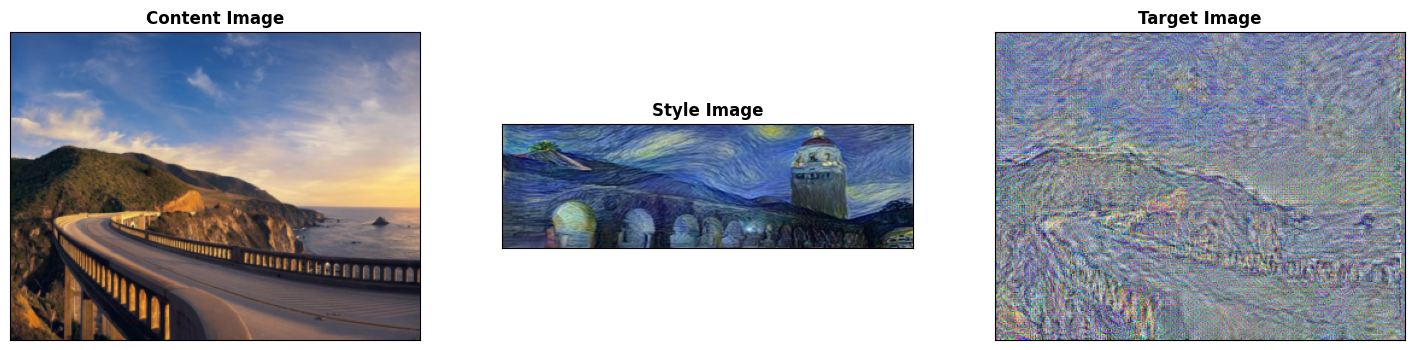

In [37]:
#Check Performance

fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = content_img.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content Image',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = style_img.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic,aspect=.6)
ax[1].set_title('Style Image',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[2].imshow(pic)
ax[2].set_title('Target Image',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()